# Neural Networks Exercise

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

# Fix the seed of the random number 
# generator so that your results will match ours
np.random.seed(1)

%load_ext autoreload
%autoreload 2

### Some code for data generation

In [4]:
def generate_dummy_circle_data(num_points):
    r = np.random.uniform(0,2,num_points)
    theta = np.random.uniform(0,2*np.pi,num_points)
    inner_circle = np.array([r*np.sin(theta), r*np.cos(theta)]).T
    
    r = np.random.uniform(5,7,num_points)
    theta = 2*np.pi*np.arange(num_points)/num_points
    outer_circle = np.array([r*np.sin(theta), r*np.cos(theta)]).T

    X = np.concatenate((inner_circle,outer_circle),axis=0)
    y = np.concatenate((np.ones(num_points),np.zeros(num_points)),axis=0)
    
    randIdx = np.arange(X.shape[0])
    np.random.shuffle(randIdx)
    
    X = X[randIdx]
    y = y[randIdx].astype(int)
    
    return X, y
    
def generate_dummy_spiral_data(num_points, num_spiral):
    r = np.random.uniform(-0.1, 0.1,num_points) + 5*np.arange(num_points)/num_points
    theta = np.random.uniform(-0.1, 0.1,num_points) + 2*np.pi*1.25*np.arange(num_points)/num_points
    spiral = np.array([r*np.sin(theta), r*np.cos(theta)]).T
    y = np.ones(num_points)

    for i in range(1,num_spiral+1):
        r = np.random.uniform(-0.1, 0.1,num_points) + 5*np.arange(num_points)/num_points
        theta = np.random.uniform(-0.1, 0.1,num_points) + 2*np.pi*1.25*np.arange(num_points)/num_points + 2*i*np.pi/num_spiral
        tmp_spiral = np.array([r*np.sin(theta), r*np.cos(theta)]).T

        spiral = np.concatenate((spiral,tmp_spiral),axis=0)
        if i % 2 == 1:
            y = np.concatenate((y,np.zeros(num_points)),axis=0)
        else:
            y = np.concatenate((y,np.ones(num_points)),axis=0)

    randIdx = np.arange(spiral.shape[0])
    np.random.shuffle(randIdx)

    X = spiral[randIdx]
    y = y[randIdx].astype(int)

    return X, y

#### Our data will look like this -- non-linearly separable 

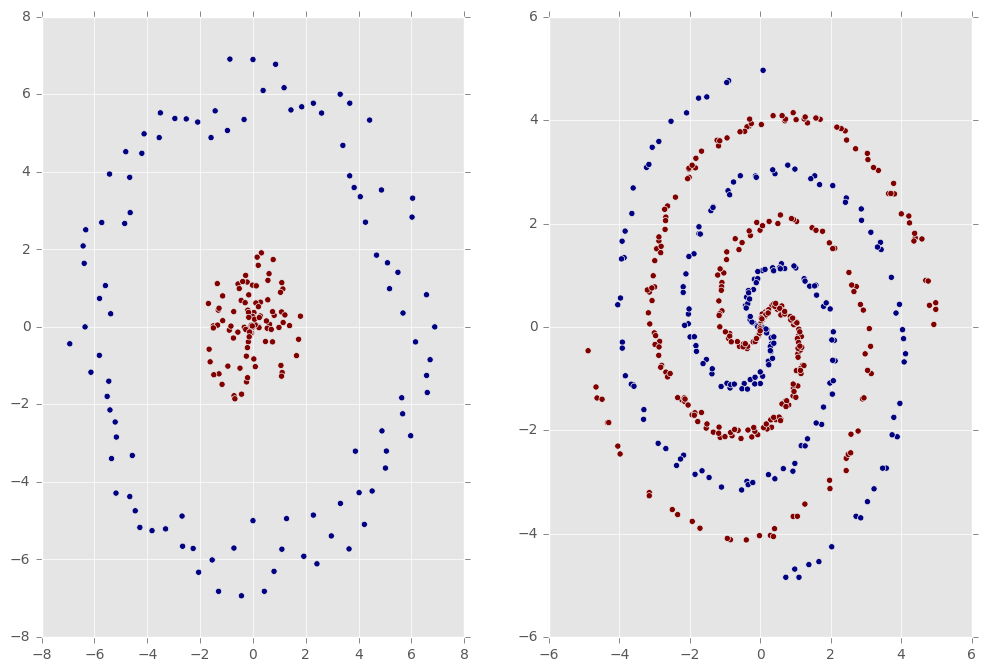

In [5]:
X_circle,y_circle = generate_dummy_circle_data(100)
plt.subplot(121)
plt.scatter(X_circle[:,0],X_circle[:,1],c=y_circle)

X_spiral,y_spiral = generate_dummy_spiral_data(100,4)
plt.subplot(122)
plt.scatter(X_spiral[:,0],X_spiral[:,1],c=y_spiral)

In [6]:
def eval_numerical_gradient(f, x, verbose=True, h=1e-5):
    """ 
    a naive implementation of numerical gradient of f at x 
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """ 

    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [7]:
from two_layer_net import NeuralNetwork

<img src="affinenetvis.png">

In [8]:
input_size = 4 # number of dimensions D
hidden_size = 10 # number of hidden nodes in the hidden layer H
num_classes = 3 # number of classes C
num_inputs =5 # number of training instances

### Prepare toy data

In [9]:
def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

X, y = init_toy_data()

### Check if implementation is correct by numerically checking the derivatives

see implementation above

In [10]:
net = NeuralNetwork(input_size, hidden_size, num_classes, hidden_activation_fn="tanh", std_dev=1e-2)
loss, grads = net.loss(X, y, reg=0.0)
for param in net.params:
    f = lambda W: net.loss(X, y, reg=0.0)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param], verbose=False)
    #print(param + "_num", param_grad_num)
    #print(param,grads[param])
    print('%s max relative error: %e' % (param, rel_error(param_grad_num, grads[param])))

W1 max relative error: 2.529552e-08
b2 max relative error: 1.503842e-08
b1 max relative error: 6.330316e-06
W2 max relative error: 1.629264e-08


<b>Outputs must be small.</b> <br>
W2 max relative error: 7.863653e-10 <br>
b2 max relative error: 7.392601e-11 <br>
b1 max relative error: 1.477116e-08 <br>
W1 max relative error: 6.375146e-08 <br>

### Train neural network now with the data

In [11]:
X = X_circle
y = y_circle

net = NeuralNetwork(X.shape[1], hidden_size=6, num_classes=2, hidden_activation_fn="relu", std_dev=1e-5)
loss_history = net.train(X, y, learning_rate=1e-1, reg=0.001, num_iters=5000,optimizer="sgd", batch_size=10, verbose=False)

#### Visualize the loss

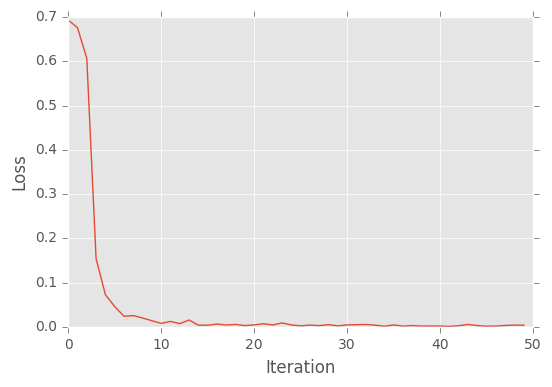

In [12]:

%matplotlib inline
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")

#### Get the training accuracy

In [14]:
Y_train_pred, scores = net.predict(X)
print("Train accuracy: {} %".format(100 - np.mean(np.abs(Y_train_pred - y)) * 100))

Train accuracy: 100.0 %


### Visualize how the data of each class are being "pulled apart" 

<IPython.core.display.Javascript object>


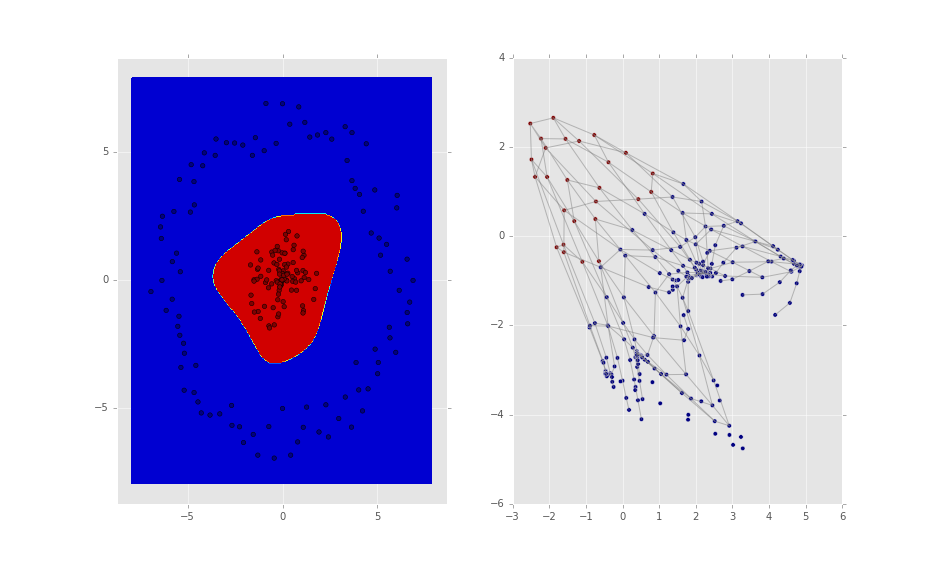

<IPython.core.display.Javascript object>


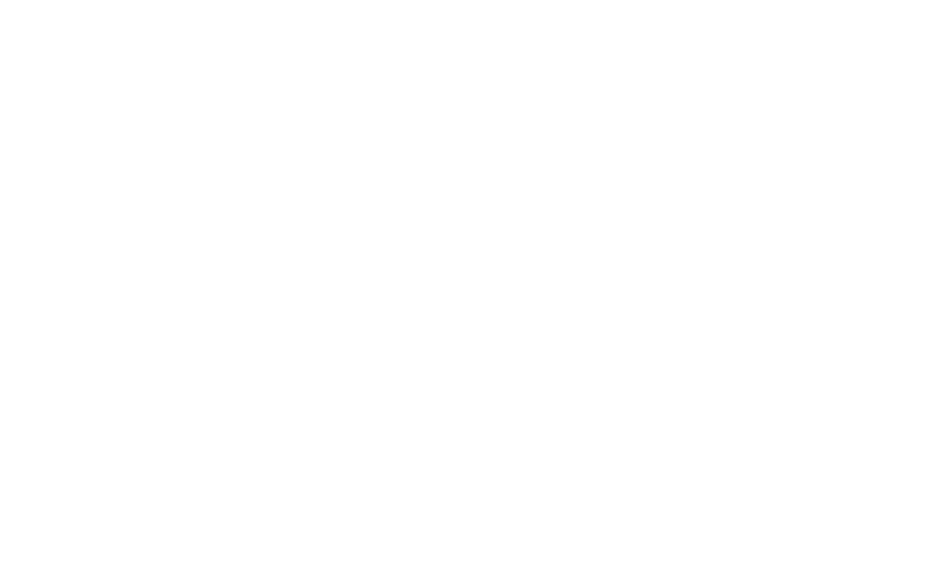

In [15]:
%matplotlib notebook
net = NeuralNetwork(X.shape[1], hidden_size=6, num_classes=2, hidden_activation_fn="tanh", std_dev=0.5)
fig = plt.figure(figsize=(13,8))
x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                     np.arange(y_min, y_max, 0.05))


x1, y1 = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 1))

grid_x = np.squeeze(np.stack((x1.ravel(),y1.ravel()))).T
x_test = np.squeeze(np.stack((xx.ravel(),yy.ravel()))).T

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i in range(1000):
    
    net.train_step(X, y, learning_rate=1e-1, reg=0.001, batch_size=10)
    if i % 10 == 0:

        Z, sc = net.predict(x_test)

        Z = Z.reshape(xx.shape)
        ax1.clear()
        ax1.contourf(xx, yy, Z)
        ax1.scatter(X[:, 0], X[:, 1], c = y,cmap="jet", edgecolors='black')
        
        Z, sc = net.predict(grid_x)
        
        ax2.clear()
        for i in range(12):
            ax2.plot(sc[i*x1.shape[0]:(i+1)*x1.shape[0],0],sc[i*x1.shape[0]: (i+1)*x1.shape[0],1], "gray", alpha=0.5)
            ax2.plot(sc[np.arange(i,x1.shape[1]**2,x1.shape[1]),0],sc[np.arange(i,x1.shape[1]**2,x1.shape[1]),1], "gray", alpha=0.5)
        ax2.scatter(sc[:,0],sc[:,1], c = Z, cmap="jet")
        
        fig.canvas.draw()


## Compare optimizers by their performances

In [19]:
import pickle
import os
from scipy.misc import imread

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f, encoding='latin1')
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


In [ ]:
# net = NeuralNetwork(X_train.shape[1], hidden_size=300, num_classes=10, hidden_activation_fn="relu", std_dev=1e-4)
# print("Ordinary Stochastic Gradient Descent")
# loss_history_sgd = net.train(X_train, y_train, learning_rate=1e-4, reg=0.001, num_iters=3000,optimizer="sgd", batch_size=200, verbose=True)

# net = NeuralNetwork(X_train.shape[1], hidden_size=300, num_classes=10, hidden_activation_fn="relu", std_dev=1e-4)
# print("Stochastic Gradient Descent with Momentum")
# loss_history_momentum = net.train(X_train, y_train, learning_rate=1e-4, reg=0.001, num_iters=3000,optimizer="momentum", batch_size=200, verbose=True)

net = NeuralNetwork(X_train.shape[1], hidden_size=300, num_classes=10, hidden_activation_fn="relu", std_dev=1e-4)
print("RMSProp")
loss_history_rmsprop = net.train(X_train, y_train, learning_rate=1e-4, reg=0.001, num_iters=3000,optimizer="rmsprop", batch_size=200, verbose=True)

net = NeuralNetwork(X_train.shape[1], hidden_size=300, num_classes=10, hidden_activation_fn="relu", std_dev=1e-4)
print("Adam")
loss_history_adam = net.train(X_train, y_train, learning_rate=1e-4, reg=0.001, num_iters=3000,optimizer="adam", batch_size=200, verbose=True)

RMSProp
iteration 0 / 3000: loss 2.302572


C:\Users\jankr\Documents\GitHub\CSC713M\06 - Neural Networks\two_layer_net.py:152: RuntimeWarning: invalid value encountered in sqrt
  self.params['W1'] = self.params['W1'] - learning_rate * (self.params['W1'] / np.sqrt(self.rmsgrad['W1'] / (1-beta2**self.t)) + epsilon)
C:\Users\jankr\Documents\GitHub\CSC713M\06 - Neural Networks\two_layer_net.py:154: RuntimeWarning: invalid value encountered in sqrt
  self.params['W2'] = self.params['W2'] - learning_rate * (self.params['W2'] / np.sqrt(self.rmsgrad['W2'] / (1-beta2**self.t)) + epsilon)
C:\Users\jankr\Documents\GitHub\CSC713M\06 - Neural Networks\two_layer_net.py:314: RuntimeWarning: invalid value encountered in maximum
  c = np.maximum(0,c)
C:\Users\jankr\Documents\GitHub\CSC713M\06 - Neural Networks\two_layer_net.py:352: RuntimeWarning: invalid value encountered in greater
  c2 = np.array([c>0][0]).astype(int)


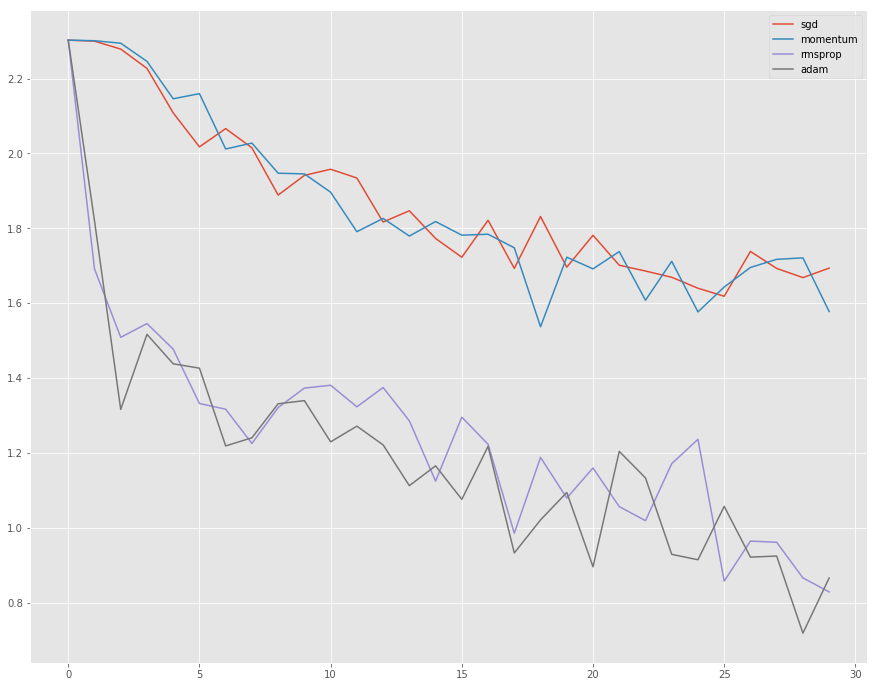

In [153]:
%matplotlib inline
plt.figure(figsize=(15,12))
plt.plot(loss_history_sgd, label="sgd")
plt.plot(loss_history_momentum, label="momentum")
plt.plot(loss_history_rmsprop, label="rmsprop")
plt.plot(loss_history_adam,label="adam")
plt.legend(loc="upper right")
plt.show()

iteration 0 / 2000: loss 2.302990
iteration 100 / 2000: loss 2.302490
iteration 200 / 2000: loss 2.297504
iteration 300 / 2000: loss 2.241852
iteration 400 / 2000: loss 2.212059
iteration 500 / 2000: loss 2.135531
iteration 600 / 2000: loss 2.073166
iteration 700 / 2000: loss 1.967874
iteration 800 / 2000: loss 2.039526
iteration 900 / 2000: loss 2.060070
iteration 1000 / 2000: loss 1.992185
iteration 1100 / 2000: loss 1.918720
iteration 1200 / 2000: loss 1.946105
iteration 1300 / 2000: loss 1.899557
iteration 1400 / 2000: loss 1.789748
iteration 1500 / 2000: loss 1.919718
iteration 1600 / 2000: loss 1.898282
iteration 1700 / 2000: loss 1.800128
iteration 1800 / 2000: loss 1.939719
iteration 1900 / 2000: loss 1.786910


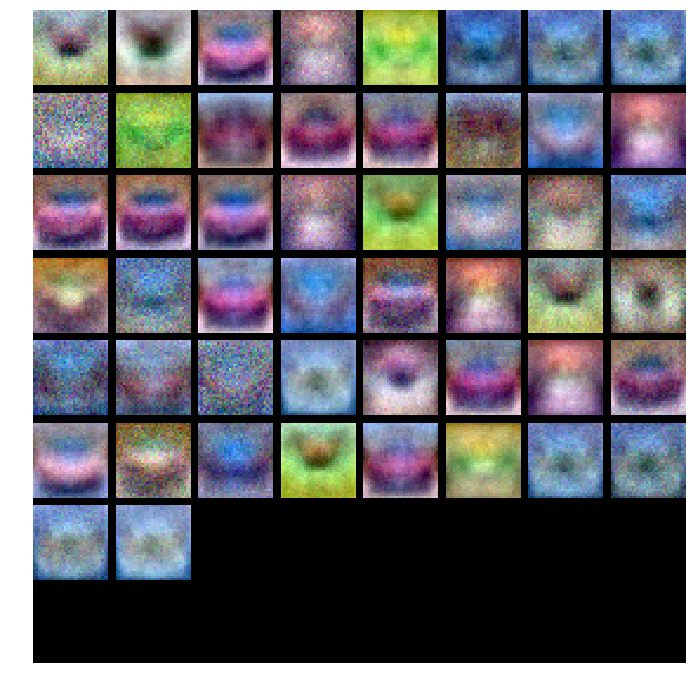

In [154]:
def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of image data to a grid for easy visualization.

    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                # grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    # grid_max = np.max(grid)
    # grid_min = np.min(grid)
    # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
    return grid

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.figure(figsize=(15,12))
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()
net = NeuralNetwork(X_train.shape[1], hidden_size=50, num_classes=10, hidden_activation_fn="relu", std_dev=1e-4)
net.train(X_train, y_train, learning_rate=1e-4, reg=0.5, num_iters=2000,optimizer="sgd", batch_size=200, verbose=True)
show_net_weights(net)